<a href="https://colab.research.google.com/github/GarimaSharda/Kaggle-Knowledge-Project-Titanic/blob/main/Kaggle_Titanic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Titanic Survival Prediction (Kaggle)**

This notebook tackles the classic Kaggle Titanic challenge as a binary classification problem: given passenger information, predict whether each person survived the disaster. The workflow starts with basic exploration and a simple baseline model, then iteratively adds richer features and more advanced modeling to improve performance and interpretability.


# **Load data and Overview**
This cell reads the Titanic train and test CSV files into pandas DataFrames and displays the first few rows. It helps verify that the files are loaded correctly and shows the available columns (PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked). Also load all required packages.

### Option to use Kaggle API or if using google collab then you can upload our downloaded dataset

In [7]:
import os
from dotenv import load_dotenv
from pathlib import Path
import pandas as pd

env_path = Path(".env")
if env_path.exists():
    load_dotenv(dotenv_path=".env")
    KAGGLE_API_TOKEN = os.environ['KAGGLE_API_TOKEN']
    KAGGLE_USERNAME = os.environ['KAGGLE_USERNAME']
    
    import subprocess, zipfile
    data_dir = Path("data")
    data_dir.mkdir(exist_ok=True)

    subprocess.run(
        ["kaggle", "competitions", "download", "-c", "titanic", "-p", str(data_dir)],
        check=True,
    )
    with zipfile.ZipFile(data_dir / "titanic.zip") as zf:
            zf.extractall(data_dir)
            
    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    gender_submission = pd.read_csv(data_dir / "gender_submission.csv")
else:
    from google.colab import files
    print('Hi, Pl upload the files.')
    uploaded = files.upload()
    train = pd.read_csv('train.csv')
    test = pd.read_csv("test.csv")
    gender_submission = pd.read_csv("gender_submission.csv")
    

In [8]:
# Use kaggle api or Upload local CSV file from your computer
# Check the data
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Just provide Kaggle API token in .env or Upload gender_submission.csv from your computer
# Display first few rows
gender_submission.head()


Saving gender_submission.csv to gender_submission (1).csv


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [33]:
# Upload file manually from your computer
uploaded = files.upload()

# Load CSV file into a DataFrame
test = pd.read_csv('test.csv')

# Display the first few rows
test.head()

Saving test.csv to test (1).csv


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# **Check shapes and missing values**
This cell prints the number of rows and columns in train and test, then counts missing values in each column. It gives an overview of data completeness and tells which features (Age, Cabin, Embarked, Fare) need imputation before modeling.

In [35]:
#Get the number of entries in each file
train_len = len(train)
test_len = len(test)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("Number of entries in train.csv:", train_len)
print("Number of entries in test.csv:", test_len)

Train shape: (891, 12)
Test shape: (418, 11)
Number of entries in train.csv: 891
Number of entries in test.csv: 418


In [36]:
#check null value
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# **Baseline Exploratory Data Analysis**

Before building any models, it is useful to look at a few simple relationships between the features and the target `Survived`.  
This section focuses on high‑level questions such as:
- Do women have higher survival rates than men?
- How does passenger class relate to survival?
- How is age distributed among survivors and non‑survivors?


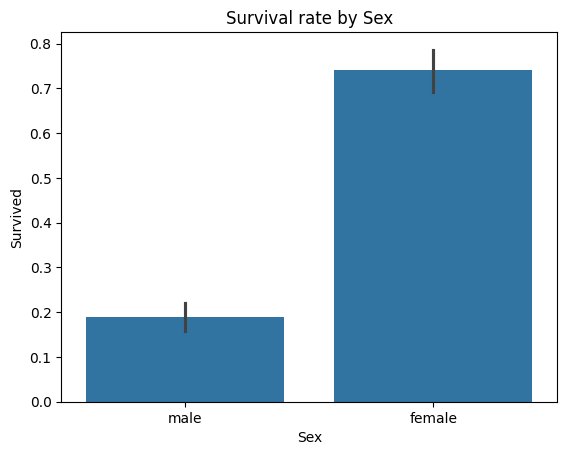

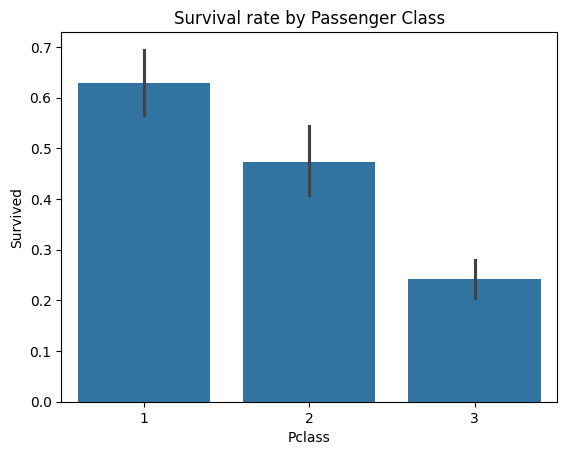

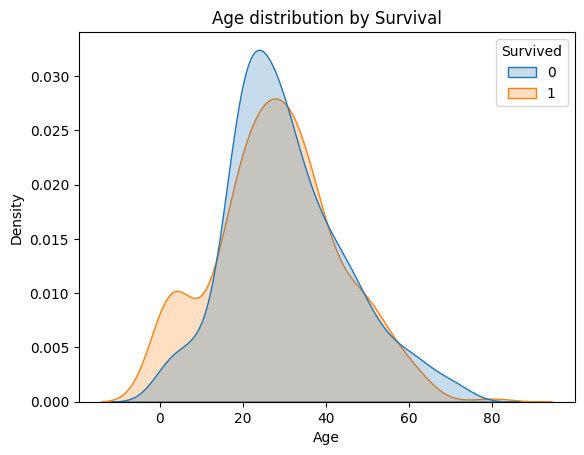

In [37]:
# Survival rate by Sex
sns.barplot(data=train, x="Sex", y="Survived")
plt.title("Survival rate by Sex")
plt.show()

# Survival rate by Pclass
sns.barplot(data=train, x="Pclass", y="Survived")
plt.title("Survival rate by Passenger Class")
plt.show()

# Age distribution by Survived
sns.kdeplot(data=train, x="Age", hue="Survived", common_norm=False, fill=True)
plt.title("Age distribution by Survival")
plt.show()



# **Baseline Preprocessing and Model**


Here a first end‑to‑end model is built using only basic cleaning and a small set of intuitive features.  
The steps are:

- Handle missing values for `Age`, `Embarked`, and `Fare` with simple strategies.
- Create a couple of straightforward features such as `FamilySize` and `HasCabin`.
- Encode categorical variables so they can be used by scikit‑learn.
- Train a baseline classifier (Random Forest) and evaluate it on a validation split.

This baseline sets a reference accuracy that later sections will try to improve on with richer features and more serious modeling.


In [38]:
train_basic = train_raw.copy()
test_basic  = test_raw.copy()

# Missing values
for df in [train_basic, test_basic]:
    df["Age"] = df.groupby(["Sex", "Pclass"])["Age"].transform(
        lambda x: x.fillna(x.median())
    )

embarked_mode = train_basic["Embarked"].mode()[0]
train_basic["Embarked"] = train_basic["Embarked"].fillna(embarked_mode)
test_basic["Embarked"]  = test_basic["Embarked"].fillna(embarked_mode)

test_basic["Fare"] = test_basic.groupby("Pclass")["Fare"].transform(
    lambda x: x.fillna(x.median())
)

# Simple features
for df in [train_basic, test_basic]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["HasCabin"] = df["Cabin"].notna().astype(int)

# Encode categoricals
for df in [train_basic, test_basic]:
    df["Sex"] = (
        df["Sex"].map({"male": 0, "female": 1})
        .fillna(-1).astype(int)
    )
    df["Embarked"] = (
        df["Embarked"].map({"S": 0, "C": 1, "Q": 2})
        .fillna(-1).astype(int)
    )

basic_features = [
    "Pclass", "Sex", "Age", "SibSp", "Parch",
    "Fare", "Embarked", "FamilySize", "HasCabin"
]

X_basic = train_basic[basic_features]
y_basic = train_basic["Survived"]
test_X_basic = test_basic[basic_features]


In [39]:
Xb_train, Xb_valid, yb_train, yb_valid = train_test_split(
    X_basic, y_basic, test_size=0.2, random_state=42, stratify=y_basic
)

rf_basic = RandomForestClassifier(
    n_estimators=200, max_depth=5, random_state=42, n_jobs=-1
)
rf_basic.fit(Xb_train, yb_train)
yb_pred = rf_basic.predict(Xb_valid)

print("Baseline validation accuracy:", accuracy_score(yb_valid, yb_pred))
print("Confusion matrix:\n", confusion_matrix(yb_valid, yb_pred))


Baseline validation accuracy: 0.7821229050279329
Confusion matrix:
 [[96 14]
 [25 44]]


The baseline model gives an initial sense of how much signal is present even with minimal feature engineering.  
Next, the notebook digs deeper into the data to uncover more detailed patterns that can inspire better features.

# **Deeper Exploratory Data Analysis**

The goal of this section is to go beyond one‑dimensional plots and examine more nuanced patterns in the data.  
Examples include:

- Survival rates by family size, to see whether travelling alone or in a group influenced outcomes.
- Interactions between features, such as survival by both sex and passenger class.
- Simple feature distributions conditioned on survival, which can reveal non‑linear effects.

These insights help motivate the advanced feature engineering steps that follow.


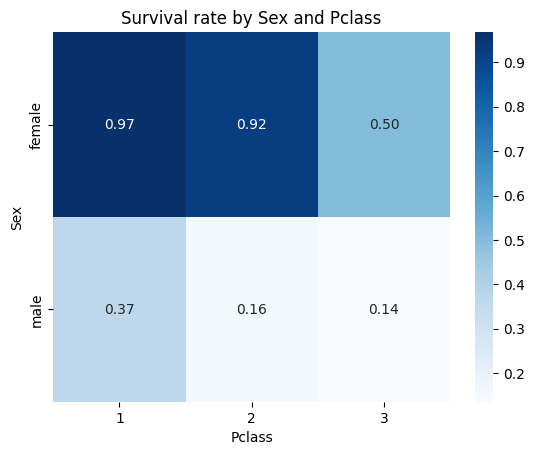

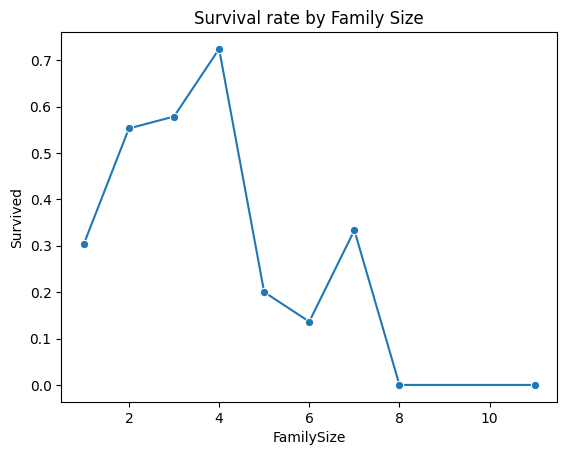

In [40]:
# Sex x Pclass survival heatmap
pivot = train_raw.pivot_table(
    index="Sex", columns="Pclass", values="Survived", aggfunc="mean"
)
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues")
plt.title("Survival rate by Sex and Pclass")
plt.show()

# Create FamilySize
if "FamilySize" not in train.columns:
    train["FamilySize"] = train["SibSp"] + train["Parch"] + 1

# Family size vs survival
train_raw["FamilySize"] = train_raw["SibSp"] + train_raw["Parch"] + 1
fs = train_raw.groupby("FamilySize")["Survived"].mean().reset_index()
sns.lineplot(data=fs, x="FamilySize", y="Survived", marker="o")
plt.title("Survival rate by Family Size")
plt.show()


# **Advanced feature engineering**

Building on the insights from the deeper EDA, this section constructs a richer set of features intended to capture more structure in the data.  
In addition to the basic features used earlier, the engineered variables include:

- **IsChild**: indicator for passengers under a certain age threshold.
- **TicketGroupSize** and **FarePerPerson**: group‑level statistics derived from shared ticket numbers.
- **AgeBand** and **FareBand**: binned versions of continuous variables to model non‑linear relationships.
- Refined family and cabin‑related features.

The result is an “advanced” feature matrix that will be used to train and compare stronger models.


In [41]:
train_adv = train_raw.copy()
test_adv  = test_raw.copy()

# Reuse same imputations
for df in [train_adv, test_adv]:
    df["Age"] = df.groupby(["Sex", "Pclass"])["Age"].transform(
        lambda x: x.fillna(x.median())
    )

embarked_mode = train_adv["Embarked"].mode()[0]
train_adv["Embarked"] = train_adv["Embarked"].fillna(embarked_mode)
test_adv["Embarked"]  = test_adv["Embarked"].fillna(embarked_mode)

test_adv["Fare"] = test_adv.groupby("Pclass")["Fare"].transform(
    lambda x: x.fillna(x.median())
)

# Advanced features
for df in [train_adv, test_adv]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsChild"] = (df["Age"] < 16).astype(int)
    df["HasCabin"] = df["Cabin"].notna().astype(int)

all_tickets = pd.concat([train_adv["Ticket"], test_adv["Ticket"]])
ticket_counts = all_tickets.value_counts()
for df in [train_adv, test_adv]:
    df["TicketGroupSize"] = df["Ticket"].map(ticket_counts)
    df["FarePerPerson"] = df["Fare"] / df["TicketGroupSize"]

for df in [train_adv, test_adv]:
    df["AgeBand"] = pd.cut(df["Age"], bins=[0, 12, 18, 30, 50, 80], labels=False)
    df["FareBand"] = pd.qcut(df["Fare"], 4, labels=False, duplicates="drop")

for df in [train_adv, test_adv]:
    df["Sex"] = (
        df["Sex"].map({"male": 0, "female": 1})
        .fillna(-1).astype(int)
    )
    df["Embarked"] = (
        df["Embarked"].map({"S": 0, "C": 1, "Q": 2})
        .fillna(-1).astype(int)
    )

adv_features = [
    "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked",
    "FamilySize", "HasCabin", "IsChild",
    "TicketGroupSize", "FarePerPerson",
    "AgeBand", "FareBand"
]

X_adv = train_adv[adv_features]
y_adv = train_adv["Survived"]
test_X_adv = test_adv[adv_features]


# **Model Comparison and Tuning**

With the advanced feature set in place, this section treats the task as a standard supervised classification problem and compares several algorithms, for example:

- Logistic Regression
- Random Forest
- Gradient Boosting

Each model is evaluated with cross‑validation to get a more stable estimate of performance.  
For the most promising model (here, a Random Forest), a small hyperparameter search is run to tune depth, number of trees, and splitting criteria. This helps reduce overfitting and squeeze out a few extra points of accuracy.


In [42]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=6, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}

for name, model in models.items():
    scores = cross_val_score(model, X_adv, y_adv, cv=cv, scoring="accuracy")
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")



LogisticRegression: mean=0.8081, std=0.0239
RandomForest: mean=0.8339, std=0.0228
GradientBoosting: mean=0.8384, std=0.0195


Optional tuning:

In [43]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [300, 600],
    "max_depth": [5, 7, 9, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

grid = GridSearchCV(
    rf, param_grid, cv=5,
    scoring="accuracy", n_jobs=-1, verbose=1
)
grid.fit(X_adv, y_adv)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)
best_rf = grid.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
Best CV score: 0.835044881049526


FEATURE IMPORTANCE

In [44]:
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({"feature": adv_features, "importance": importances}) \
    .sort_values("importance", ascending=False)
feat_imp


,feature,importance
1,Sex,0.293974
5,Fare,0.126965
2,Age,0.126151
11,FarePerPerson,0.124670
0,Pclass,0.055297
10,TicketGroupSize,0.049251
7,FamilySize,0.039573
8,HasCabin,0.037391
12,AgeBand,0.036529
13,FareBand,0.032808


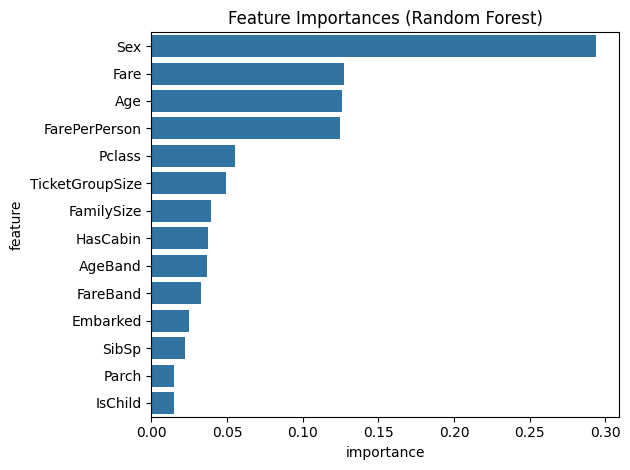

In [45]:
sns.barplot(data=feat_imp, x="importance", y="feature")
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


The feature importance plot highlights which engineered variables contribute most to the tuned model.  
This not only helps explain the model’s behaviour (for example, the strong impact of `Sex`, `FarePerPerson`, and `Age`), but also validates that the additional engineering work is actually being used by the classifier.

# **Fit on all data and generate Kaggle submission**

In the final step, the best model from the comparison and tuning phase is retrained on the full training dataset using the advanced feature set.  
The trained model is then applied to the processed test data to generate survival predictions, which are saved in `submission_final.csv` in the exact format required by Kaggle (`PassengerId`, `Survived`).

This file can be uploaded to the Titanic competition page to obtain a public leaderboard score.

In [46]:
best_rf.fit(X_adv, y_adv)
test_pred = best_rf.predict(test_X_adv)

submission = pd.DataFrame({
    "PassengerId": test_raw["PassengerId"],
    "Survived": test_pred.astype(int)
})
submission.to_csv("submission_final.csv", index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


**## Conclusions and next steps**

This notebook followed a typical machine learning workflow:

- Performed initial EDA and built a simple baseline model with minimal features.
- Used deeper analysis to inform more targeted feature engineering.
- Compared multiple algorithms on an advanced feature set and tuned the best performer.
- Generated a final Kaggle submission from the tuned model.

Possible extensions include trying ensemble methods, exploring alternative encodings, or adding model‑agnostic explainability techniques such as SHAP or permutation importance.
